# Setup

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from datetime import datetime

# SKlearn 
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,accuracy_score
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

# Read Incidents Dataset - Capstone I 
incidents = pd.read_csv('../data/Aggregated/incidents.csv')
incidents.columns

Index(['Incident ID', 'Incident Date', 'Incident Time', 'Day',
       'Incident County Name', 'Incident State', 'Victim ID', 'Gender Desc',
       'Age Range', 'Race', 'Ethnicity Desc', 'Naloxone Administered',
       'Survive', 'Response Desc', 'All Drugs', 'Incident Date ym'],
      dtype='object')

In [105]:
cluster_Map = pd.read_csv('..\data\Aggregated\cluster_mapping.csv')

# Pre-processing

## Multi-drug use

In [106]:
incidents['Multiple Drugs'] = 0
incidents.loc[incidents['All Drugs'].str.contains(' | ', regex = False), 'Multiple Drugs'] = 1
incidents[incidents['Multiple Drugs'] == 1].shape

(8050, 17)

## Fentanyl

In [107]:
incidents['Fentanyl'] = 0
incidents.loc[incidents['All Drugs'].str.contains('FENTANYL', regex = False), 'Fentanyl'] = 1
incidents['Fentanyl'].value_counts()

0    13342
1     7255
Name: Fentanyl, dtype: int64

## Year, Month and Age Range

In [108]:
def agerange_weekend(df):
    
    df_cpy = df.copy()
    for i, row in df_cpy.iterrows():
        
        # Weekend Binary Feature
        if row['Day'] in ['Friday', "Saturday", "Sunday"]:
            df_cpy.loc[i,'Weekend_OD'] = 1
        else:
            df_cpy.loc[i,'Weekend_OD'] = 0
        
        # Season Features - Winter, Spring, Summer and Fall
        if row['month'] in [1, 12, 2]:
            df_cpy.loc[i,'Season'] = 'Winter'
            
        elif row['month'] in [3,4, 5]:
            df_cpy.loc[i,'Season'] = 'Spring'
            
        elif row['month'] in [6, 7, 8]:
            df_cpy.loc[i,'Season'] = 'Summer'
            
        elif row['month'] in [9, 10, 11]:
            df_cpy.loc[i,'Season'] = 'Fall' 
        
        # Age Binary feature - over/below 40 years old
        if row['Age Range'] in ['0 - 9', '10 - 14', '15 - 19', '20 - 24','25 - 29', '30 - 39']:
            df_cpy.loc[i,'Over 40'] = 0
        else:    
            df_cpy.loc[i,'Over 40'] = 1
        
    # Ensure dtype for binary features is int
    df_cpy['Over 40'] = df_cpy['Over 40'].astype(int)
    df_cpy['Weekend_OD'] = df_cpy['Weekend_OD'].astype(int)
        
    return df_cpy

In [109]:
incidents["year"] = incidents['Incident Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').year)
incidents["month"] = incidents['Incident Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').month)

# Fix value typo
incidents["Age Range"] = incidents["Age Range"].apply(lambda x: "10 - 14" if x == "14-Oct" else x)

# Sanity Check
incidents['Age Range'].value_counts()

30 - 39    7653
25 - 29    4082
40 - 49    3434
20 - 24    2030
50 - 59    1871
60 - 69     634
0 - 9       530
15 - 19     276
70 - 79      70
80 - *       10
10 - 14       7
Name: Age Range, dtype: int64

In [110]:
incidents2 = agerange_weekend(incidents)
incidents2.head(2)

,Incident ID,Incident Date,Incident Time,Day,Incident County Name,Incident State,Victim ID,Gender Desc,Age Range,Race,...,Response Desc,All Drugs,Incident Date ym,Multiple Drugs,Fentanyl,year,month,Weekend_OD,Season,Over 40
0,1,1/4/2018,0:42:00,Thursday,Delaware,Pennsylvania,1,Male,50 - 59,White,...,NO RESPONSE TO NALOXONE,COCAINE/CRACK | HEROIN,2018,1,0,2018,1,0,Winter,1
1,26,1/26/2018,9:14:00,Friday,Chester,Pennsylvania,5,Male,25 - 29,White,...,None,HEROIN,2018,0,0,2018,1,1,Winter,0


In [111]:
incidents3 = pd.merge(incidents2,cluster_Map, how="inner",left_on = 'Incident County Name',right_on = 'County')

In [112]:
incidents3['Cluster'] = incidents3['Cluster'].astype(str)

In [113]:
def isphila(df):
    for i, row in df.iterrows():
        if row['Incident County Name'] == 'Philadelphia':
            df.loc[i,'Phila'] = 1
        else:
            df.loc[i,'Phila'] = 0
    return (df) 

In [114]:
incidents3 = isphila(incidents3.copy())

In [115]:
incidents3['Phila'] = incidents3['Phila'].astype(int)

In [116]:
#### Good

X = incidents3[['Over 40','Naloxone Administered','Fentanyl','Multiple Drugs']]
y = incidents3[['Survive']]

# Class weights are required because of class imbalance issue
class_weight_m = dict(y['Survive'].value_counts())
class_weight_m

{0: 15472, 1: 5097}

## Pipeline Definition

In [78]:
##pipeline  NOT GOOD

#label_features =['Cluster']
#label_transformer = OneHotEncoder(sparse = False, handle_unknown = 'ignore')



#preprocessor = ColumnTransformer(
 #   transformers=[
  #      ('label', label_transformer, label_features)
   #     ])   


#rf_model =  Pipeline(steps=[('preprocessor', preprocessor),
 #                     ('randomforest', RandomForestClassifier(n_estimators=1000,
  #                                                           class_weight=class_weight_m))])

In [117]:
#### Good

# Random Forest
rf_model =  Pipeline(steps=[
                      ('randomforest', RandomForestClassifier(n_estimators=1000,
                                                              class_weight=class_weight_m))])

# Logistic regression
lr_model = Pipeline(steps=[
                           ('logisticregression', LogisticRegression(class_weight=class_weight_m))])

# Decision Tree
dt_model =  Pipeline(steps=[
                           ('decisiontree',DecisionTreeClassifier(random_state = 42,
                                                                  class_weight=class_weight_m))])

## Split data

In [118]:
# Split data with stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

## Class Imbalance

In [81]:
total_od = sum(y.value_counts())
ax = y.value_counts().plot(kind="bar",
                           rot = 25,
                           title = "Class Distribution",
                           ylabel = "Number of Overdoses",
                           xlabel = "Survival",
                           grid = True,
                           color = ["Blue", "Orange"])
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, _: format(int(x), ',')))
ax.set_xticklabels(["Survived", "Died"])

for patch in ax.patches:
    ax.annotate('{:.2f}%'.format(patch.get_height() / total_od * 100),                # Count
               (patch.get_x() + 0.15, patch.get_height()+150),          # x,y coordinates for label.
               fontsize=12)  

AttributeError: 'DataFrame' object has no attribute 'value_counts'

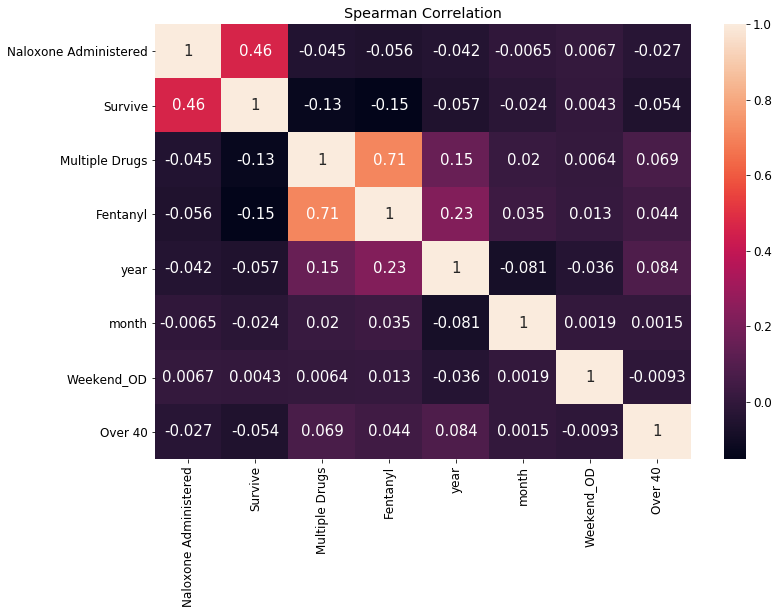

In [82]:
cor = incidents2.drop(['Incident ID', 'Victim ID', 'Incident Date ym'], axis = 1).corr(method = "spearman")
plt.figure(figsize = (12,8))
plt.title("Spearman Correlation")
sns.heatmap(cor, annot = True, cmap = 'rocket',annot_kws={"fontsize":15})

## Baseline

Dummy classifier predict survived (1) when Naloxone was administered AND there were no multiple drugs. Otherwise died.

In [83]:
dummy_clf = X_train[["Naloxone Administered", 'Multiple Drugs']].apply(lambda x: 1 if x[0] == 1 and x[1] == 0 else 0, axis = 1)
print(classification_report(y_train, dummy_clf, target_names=["Died", "Survived"]))

print(matthews_corrcoef(y_train,dummy_clf))

              precision    recall  f1-score   support

        Died       0.36      0.84      0.51      3823
    Survived       0.91      0.52      0.66     11603

   micro avg       0.59      0.59      0.59     15426
   macro avg       0.63      0.68      0.58     15426
weighted avg       0.77      0.59      0.62     15426

0.30698195777698684


## Fit Models

In [119]:
# Random Forest
rf_model.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('randomforest', RandomForestClassifier(bootstrap=True, class_weight={0: 15472, 1: 5097},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False))])

In [120]:
# Logistic Regression
lr_model.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('logisticregression', LogisticRegression(C=1.0, class_weight={0: 15472, 1: 5097}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])

In [121]:
# Decision Tree
dt_model.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('decisiontree', DecisionTreeClassifier(class_weight={0: 15472, 1: 5097}, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'))])

## Predict

In [122]:
# Random Forest 
predictions_classweights = rf_model.predict(X_test)
print("accuracy:",accuracy_score(y_test, predictions_classweights))

accuracy: 0.7828115885669843


In [123]:
# Logistic Regression
LR_predictions_classweights = lr_model.predict(X_test)
print("accuracy:",accuracy_score(y_test, LR_predictions_classweights))


accuracy: 0.7828115885669843


In [124]:
# Decision Tree
dt_predictions_classweights = dt_model.predict(X_test)
print("accuracy:",accuracy_score(y_test, dt_predictions_classweights))


accuracy: 0.7828115885669843


In [145]:
from sklearn import tree


In [146]:
tree.plot_tree(dt_model)

AttributeError: module 'sklearn.tree' has no attribute 'plot_tree'

# Cross Validation

In [125]:
def cross_validation(X, y, model, n_splits = 5,  **kwargs):
    
    # KFold object
    kf = StratifiedKFold(n_splits=n_splits,random_state=0, shuffle=True)
    
    # Empty lists
    acc_score = []
    pred = []
    y_test_all = []
    pred_prob = []
    
    # KFold iterations
    for i, (train_index, test_index) in enumerate(kf.split(X,y)):
        print(f"Run #{i}")
        
        # Train and test features and target
        X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
        # Fit and score model
        model.fit(X_train,y_train)
        print(model.score(X_test, y_test))
        num = model.score(X_test, y_test)
        num = num.astype(float)
        acc_score.append(num)
        
        # Predict
        predictions_classweights = model.predict(X_test)
        proba = model.predict_proba(X_test)
        pred_prob.append(proba)                           
        
        # Store results
        pred.append(predictions_classweights)
        y_test_all.append(y_test)
        
        # Print ROC AUC results
        print(f"ROC AUC Score: {roc_auc_score(y_test,predictions_classweights)}", end = "\n")
        
        print(f"Matthews Correlation: {matthews_corrcoef(y_test,predictions_classweights)}", end = "\n\n")
        
    # Return lists
    return pred, y_test_all, pred_prob


In [126]:
rf_cross_pred, rf_cross_test, rf_cross_prob = cross_validation(X, y, rf_model)

Run #0
0.7752126366950183
ROC AUC Score: 0.7434270962019703
Matthews Correlation: 0.4528470673336938

Run #1
0.7771567436208991
ROC AUC Score: 0.7473486648294212
Matthews Correlation: 0.4593770386910319

Run #2
0.7896912229516169
ROC AUC Score: 0.7598457364375507
Matthews Correlation: 0.48520517851972367

Run #3
0.7831266715292974
ROC AUC Score: 0.7541661565358385
Matthews Correlation: 0.4726842670691011

Run #4
0.7760758570386579
ROC AUC Score: 0.7412528157635818
Matthews Correlation: 0.45068225713484533



In [127]:
lr_cross_pred,lr_cross_test, lr_cross_prob = cross_validation(X, y, lr_model)

Run #0
0.7752126366950183
ROC AUC Score: 0.7434270962019703
Matthews Correlation: 0.4528470673336938

Run #1
0.7771567436208991
ROC AUC Score: 0.7473486648294212
Matthews Correlation: 0.4593770386910319

Run #2
0.7896912229516169
ROC AUC Score: 0.7598457364375507
Matthews Correlation: 0.48520517851972367

Run #3
0.7831266715292974
ROC AUC Score: 0.7541661565358385
Matthews Correlation: 0.4726842670691011

Run #4
0.7760758570386579
ROC AUC Score: 0.7412528157635818
Matthews Correlation: 0.45068225713484533



In [128]:
dt_cross_pred, dt_cross_test, dt_cross_prob= cross_validation(X, y, dt_model)

Run #0
0.7752126366950183
ROC AUC Score: 0.7434270962019703
Matthews Correlation: 0.4528470673336938

Run #1
0.7771567436208991
ROC AUC Score: 0.7473486648294212
Matthews Correlation: 0.4593770386910319

Run #2
0.7896912229516169
ROC AUC Score: 0.7598457364375507
Matthews Correlation: 0.48520517851972367

Run #3
0.7831266715292974
ROC AUC Score: 0.7541661565358385
Matthews Correlation: 0.4726842670691011

Run #4
0.7760758570386579
ROC AUC Score: 0.7412528157635818
Matthews Correlation: 0.45068225713484533



In [129]:
def change_threshold(pred_prob_all, 
                     y_test_all, 
                     threshold: int = .5,
                     log: bool = False):
    y_test_master = pd.concat(y_test_all)
    
    probs = [pd.DataFrame(a, columns = ['zero', 'one']) for a in pred_prob_all]
    probs_final = pd.concat(probs)
    probs_final = probs_final[['one']]
    
    probs_final['one'] = np.select([probs_final['one'] > threshold],  ### setting threshold
                                    [1],
                                    default=0)
    
    conf_matrix = confusion_matrix(y_test_master,probs_final)
    roc_score = roc_auc_score(y_test_master,probs_final)
    matthews_score = matthews_corrcoef(y_test_master,probs_final)
    target_names = ['Died', 'Survived']
    clf_report = classification_report(y_test_master, probs_final, target_names=target_names)
    if log:
        print("Confusion Matrix: ")
        print(conf_matrix, end = "\n\n")

         # Print ROC AUC results
        print(f"ROC AUC Score: {roc_score}", end = "\n")
        print(f"Matthews Correlation: {matthews_score}", end = "\n\n")

        
        print("Classification Report: ")
        print(clf_report)
    
    
    
    return conf_matrix, roc_score, matthews_score, clf_report, probs_final


## Print classification report
# _ = change_threshold(...)
# print("".join(_[3]))

In [ ]:
lr_cross_pred,lr_cross_test, lr_cross_prob

In [ ]:
dt_cross_pred, dt_cross_test, dt_cross_prob= cross_validation(X, y, dt_model)

In [143]:
change_threshold(dt_cross_prob, dt_cross_test, .65, log = True)

Confusion Matrix: 
[[ 3747  1350]
 [ 4503 10969]]

ROC AUC Score: 0.7220482172736199
Matthews Correlation: 0.39119485085824784

Classification Report: 
              precision    recall  f1-score   support

        Died       0.45      0.74      0.56      5097
    Survived       0.89      0.71      0.79     15472

   micro avg       0.72      0.72      0.72     20569
   macro avg       0.67      0.72      0.68     20569
weighted avg       0.78      0.72      0.73     20569



(array([[ 3747,  1350],
        [ 4503, 10969]], dtype=int64),
 0.7220482172736199,
 0.39119485085824784,
 '              precision    recall  f1-score   support\n\n        Died       0.45      0.74      0.56      5097\n    Survived       0.89      0.71      0.79     15472\n\n   micro avg       0.72      0.72      0.72     20569\n   macro avg       0.67      0.72      0.68     20569\nweighted avg       0.78      0.72      0.73     20569\n',
       one
 0       1
 1       1
 2       1
 3       1
 4       1
 5       1
 6       0
 7       0
 8       1
 9       1
 10      1
 11      0
 12      1
 13      0
 14      1
 15      1
 16      0
 17      1
 18      0
 19      1
 20      0
 21      0
 22      0
 23      0
 24      0
 25      0
 26      1
 27      1
 28      0
 29      1
 ...   ...
 4083    1
 4084    0
 4085    0
 4086    0
 4087    1
 4088    1
 4089    1
 4090    0
 4091    1
 4092    0
 4093    1
 4094    1
 4095    0
 4096    1
 4097    1
 4098    0
 4099    1
 4100    0
 4101

In [140]:
change_threshold(lr_cross_prob, lr_cross_test, .60, log = True)

Confusion Matrix: 
[[ 3692  1405]
 [ 3989 11483]]

ROC AUC Score: 0.7332635381864832
Matthews Correlation: 0.4163952372354537

Classification Report: 
              precision    recall  f1-score   support

        Died       0.48      0.72      0.58      5097
    Survived       0.89      0.74      0.81     15472

   micro avg       0.74      0.74      0.74     20569
   macro avg       0.69      0.73      0.69     20569
weighted avg       0.79      0.74      0.75     20569



(array([[ 3692,  1405],
        [ 3989, 11483]], dtype=int64),
 0.7332635381864832,
 0.4163952372354537,
 '              precision    recall  f1-score   support\n\n        Died       0.48      0.72      0.58      5097\n    Survived       0.89      0.74      0.81     15472\n\n   micro avg       0.74      0.74      0.74     20569\n   macro avg       0.69      0.73      0.69     20569\nweighted avg       0.79      0.74      0.75     20569\n',
       one
 0       1
 1       1
 2       1
 3       1
 4       1
 5       1
 6       0
 7       0
 8       1
 9       1
 10      1
 11      0
 12      1
 13      0
 14      1
 15      1
 16      0
 17      1
 18      0
 19      1
 20      0
 21      0
 22      0
 23      0
 24      0
 25      0
 26      1
 27      1
 28      0
 29      1
 ...   ...
 4083    1
 4084    0
 4085    0
 4086    0
 4087    1
 4088    1
 4089    1
 4090    0
 4091    1
 4092    0
 4093    1
 4094    1
 4095    0
 4096    1
 4097    1
 4098    0
 4099    1
 4100    0
 4101 

In [133]:
change_threshold(rf_cross_prob, rf_cross_test, .65, log = True)

Confusion Matrix: 
[[ 3662  1435]
 [ 3996 11476]]

ROC AUC Score: 0.7300944154955396
Matthews Correlation: 0.4109878636858169

Classification Report: 
              precision    recall  f1-score   support

        Died       0.48      0.72      0.57      5097
    Survived       0.89      0.74      0.81     15472

   micro avg       0.74      0.74      0.74     20569
   macro avg       0.68      0.73      0.69     20569
weighted avg       0.79      0.74      0.75     20569



(array([[ 3662,  1435],
        [ 3996, 11476]], dtype=int64),
 0.7300944154955396,
 0.4109878636858169,
 '              precision    recall  f1-score   support\n\n        Died       0.48      0.72      0.57      5097\n    Survived       0.89      0.74      0.81     15472\n\n   micro avg       0.74      0.74      0.74     20569\n   macro avg       0.68      0.73      0.69     20569\nweighted avg       0.79      0.74      0.75     20569\n',
       one
 0       1
 1       1
 2       1
 3       1
 4       1
 5       1
 6       0
 7       0
 8       1
 9       1
 10      1
 11      0
 12      1
 13      0
 14      1
 15      1
 16      0
 17      1
 18      0
 19      1
 20      0
 21      0
 22      0
 23      0
 24      0
 25      0
 26      1
 27      1
 28      0
 29      1
 ...   ...
 4083    1
 4084    0
 4085    0
 4086    0
 4087    1
 4088    1
 4089    1
 4090    0
 4091    1
 4092    0
 4093    1
 4094    1
 4095    0
 4096    1
 4097    1
 4098    0
 4099    1
 4100    0
 4101 

In [132]:
change_threshold(rf_cross_prob, rf_cross_test, .7)
thresholds_ls, matthews_score_ls, roc_score_ls = [], [], []

for i  in range(20, 95, 5):
    threshold = i / 100
    thresholds_ls.append(threshold)
    _ = change_threshold(rf_cross_prob, rf_cross_test, threshold)
    matthews_score_ls.append(_[2])
    roc_score_ls.append(_[1])

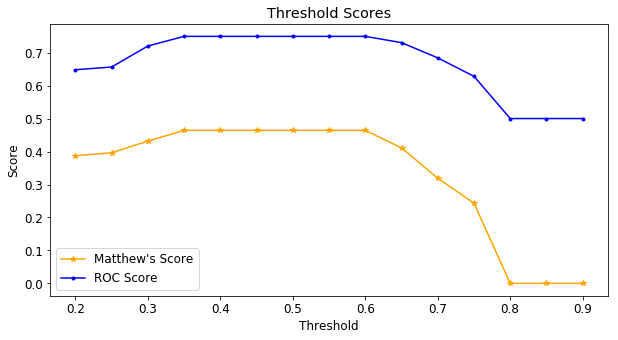

In [131]:

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(thresholds_ls, matthews_score_ls , marker = "*", color = 'Orange', label='Matthew\'s Score')
ax.plot(thresholds_ls, roc_score_ls, marker='.', color = 'Blue', label='ROC Score')
ax.set_xlabel("Threshold", fontsize = 12)
ax.set_ylabel("Score", fontsize = 12)
ax.set_title("Threshold Scores")
plt.rcParams.update({"font.size": 12})
plt.legend()

## ROC Plot

In [98]:
def plot_roc(pred_probs, y_test, threshold):
    # probs = [pd.DataFrame(a, columns = ['zero', 'one']) for a in pred_probs]
    # probs_final = pd.concat(probs)
    # probs_final = probs_final[['one']]
    probs_final = change_threshold(pred_probs, y_test, threshold = threshold)[4]
    y_test_master = pd.concat(y_test)
    
    fpr, tpr, _ = roc_curve(y_test_master,probs_final)
    auc = roc_auc_score(y_test_master,probs_final)
    plt.figure(figsize=(10,10))
    plt.plot(fpr,tpr,label=" auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

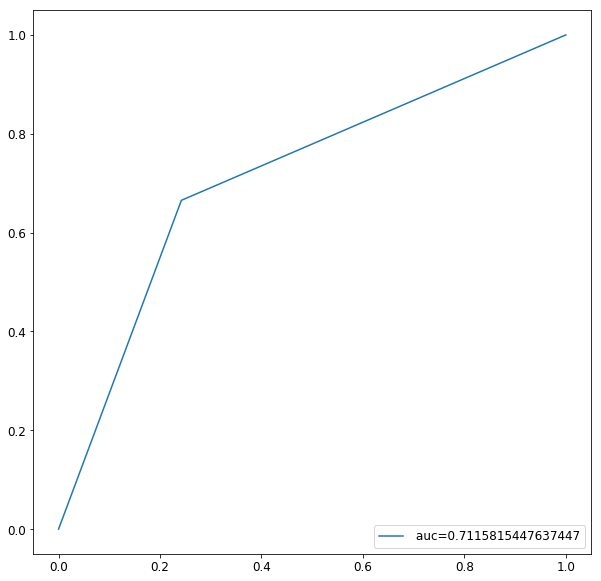

In [99]:
plot_roc(rf_cross_prob, rf_cross_test, 0.65)

# Feature Importance

In [100]:
# for gini importance
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

In [101]:
def row_to_dict(x,y=None):
    return X.apply(dict,axis=1)
    
def plot_importance(X, y, model, rot = 75, figsize = (20,5), kind = "bar"):
    ft = FunctionTransformer(row_to_dict, validate=False)
    dv = DictVectorizer()

    pipe = make_pipeline(ft,dv,model)
    pipe.fit(X,y)
    feature_importances = zip(dv.feature_names_,model[0].feature_importances_)
    
    feats = {}
    for feature, importance in zip(dv.feature_names_,feature_importances):
        feats[feature] = importance
        
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    importances.sort_values(by='Gini-importance').plot(kind=kind, rot=rot, figsize = figsize, fontsize=16)

In [102]:
rf_model[0].feature_importances_

TypeError: 'Pipeline' object is not subscriptable

In [103]:
plot_importance(X, y, rf_model, rot = 75, figsize = (20,5))

TypeError: 'Pipeline' object is not subscriptable

In [ ]:
plot_importance(X, y, dt_model, rot = 75, figsize = (20,5))